# Libs and pre-definitions

In [1]:
import os
DATA_PATH = os.path.abspath('/home/luis-felipe/Uncertainty_Estimation/data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.abspath('/home/luis-felipe/Uncertainty_Estimation/torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.abspath('/home/luis-felipe/Uncertainty_Estimation/notebook-scripts/paper1/figs')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict

In [3]:
%matplotlib inline

In [4]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [5]:
import NN_models as models
from NN_models.mimo import MIMOModel
import NN_utils as utils
import NN_utils.train_and_eval as TE
import cifar_data


In [6]:
from uncertainty.MonteCarlo_Dropout import MonteCarloDropout
from uncertainty.ensemble import Ensemble
import uncertainty.metrics as metrics

from uncertainty.mimo import MIMO_ensemble
from uncertainty import TestAugmentation as TTA

# Analysis

## Definitions

In [7]:
MODEL_ARC = 'VGG_16'
DATA = 'Cifar100'
NAME = MODEL_ARC +'_' + DATA 

data = cifar_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

model_path = os.path.join(PATH_MODELS,MODEL_ARC)
weights_path = os.path.join(model_path,DATA)

Files already downloaded and verified
Files already downloaded and verified


## Upload Models

In [8]:
files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
files = sorted(files)

In [9]:
models_dict = defaultdict()
for s in files:
    print(s)
    models_dict[s.replace('.pt','')] = model_class(num_classes = data.n_classes).to(dev)
    state_dict = torch.load(os.path.join(weights_path,s))
    models_dict[s.replace('.pt','')].load_state_dict(state_dict)
    models_dict[s.replace('.pt','')].eval()
    models_dict[s.replace('.pt','')].softmax = True

VGG16_100_ensemble_0.pt
VGG16_100_ensemble_1.pt
VGG16_100_ensemble_2.pt
VGG16_100_ensemble_3.pt
VGG_16_100_ensemble_4_checkpoint.pt
VGG_16_100_ensemble_5_checkpoint.pt
VGG_16_100_ensemble_6_checkpoint.pt
VGG_16_100_ensemble_7_checkpoint.pt


In [10]:
MAIN_MODEL_AS_MAX_ACC = 0
max_acc = 0
for n,m in models_dict.items():
    print(n)
    acc = TE.model_acc(m,data.test_dataloader)
    print(f'Acurácia = {acc}')
    if MAIN_MODEL_AS_MAX_ACC and acc > max_acc:
        main_model = m
        max_acc = acc
else:
    main_model = models_dict[files[1].replace('.pt','')]

VGG16_100_ensemble_0


/home/luis-felipe/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Acurácia = 71.5
VGG16_100_ensemble_1
Acurácia = 71.3
VGG16_100_ensemble_2
Acurácia = 71.23
VGG16_100_ensemble_3
Acurácia = 71.2
VGG_16_100_ensemble_4_checkpoint
Acurácia = 71.33
VGG_16_100_ensemble_5_checkpoint
Acurácia = 72.48
VGG_16_100_ensemble_6_checkpoint
Acurácia = 71.89
VGG_16_100_ensemble_7_checkpoint
Acurácia = 71.63


## Plots

### Deterministic

In [11]:
name = NAME + '_Deterministic'

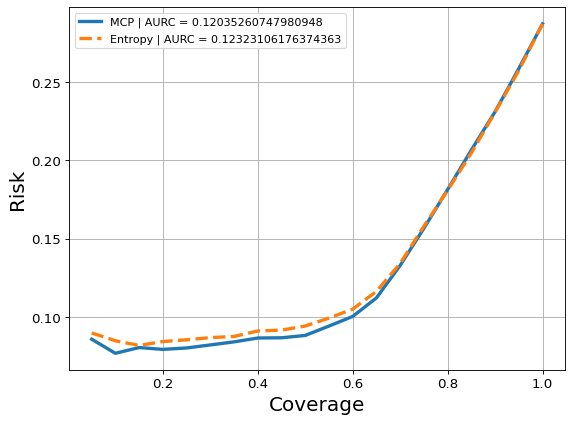

In [12]:
main_model.eval()
RC = metrics.selective_metrics(main_model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.plot_RC(aurc = True)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Deep Ensemble

In [13]:
name = NAME + '_DeepEnsemble'

In [14]:
model = Ensemble(models_dict).to(dev)
print(f'Ensemble Total Accuracy: {TE.model_acc(model,data.test_dataloader)}')

Ensemble Total Accuracy: 76.21


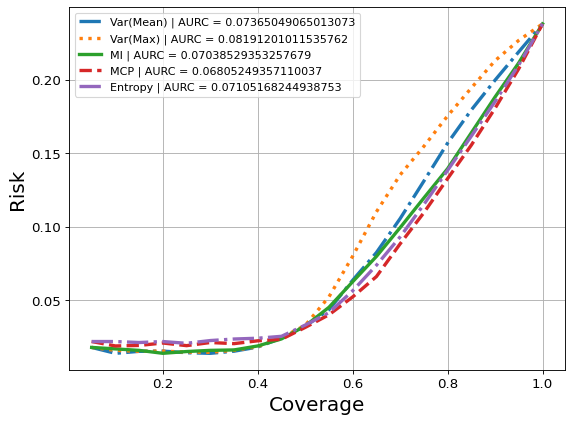

In [15]:
RC = metrics.selective_metrics(model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.plot_RC(aurc = True)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### MonteCarlo Dropout

In [16]:
N_SAMPLES = 10

#### MCD Ensemble

In [17]:
name = NAME + '_MCD_Ens'

In [18]:
model = MonteCarloDropout(main_model,return_uncs = False,n_samples = N_SAMPLES, as_ensemble = True).to(dev)
#print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model,data.test_dataloader)}')

In [19]:
RC = metrics.selective_metrics(model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))

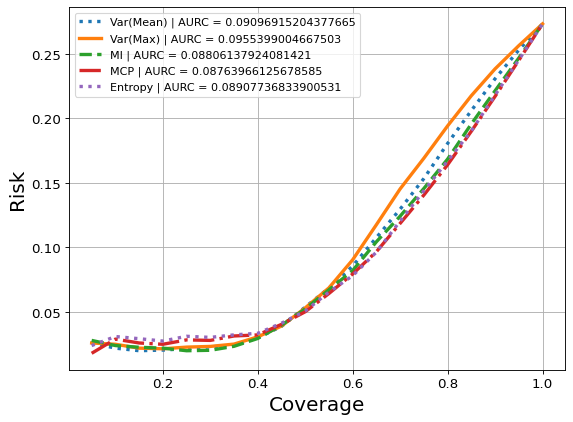

In [20]:

RC.plot_RC(aurc = True)
#plt.ylim(0,0.005)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))
MCD_ens = RC.risk['MCP']

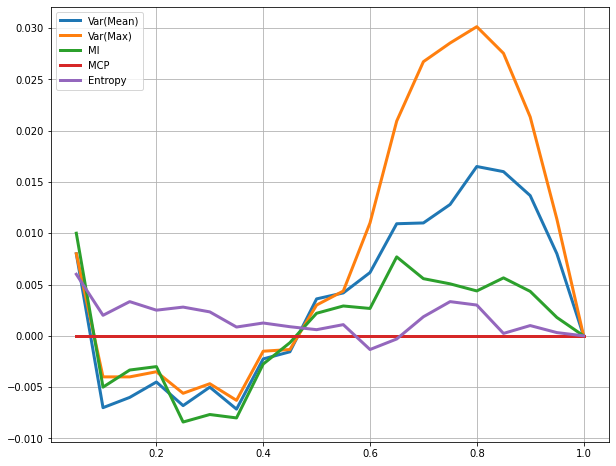

In [21]:
plt.figure(figsize=(10,8))
for name,r in RC.risk.items():
    
    plt.plot(RC.c_list,r-MCD_ens,label = name,linewidth = 3)
#plt.ylim(-0.005,0.005)
plt.grid()
plt.legend()

plt.show()

In [22]:
RC.plot_thresholds(normalized = False)
plt.yscale('log')

TypeError: plot_thresholds() got an unexpected keyword argument 'normalized'

#### Deterministic inference

In [ ]:
name = NAME + '_MCD_Det'

In [ ]:
model = MonteCarloDropout(main_model,n_samples = N_SAMPLES, as_ensemble = False).to(dev)

In [ ]:
RC = metrics.selective_metrics(model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))

In [ ]:
RC.plot_RC(aurc = True)
#plt.xlim(0,0.8)
#plt.ylim(0,0.01)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))
MCD_det = RC.risk['MCP (MCD)']

In [ ]:
plt.figure(figsize=(10,8))
for name,r in RC.risk.items():
    
    plt.plot(RC.c_list,r-MCD_det,label = name,linewidth = 3)
#plt.ylim(-0.005,0.005)
plt.grid()
plt.legend()

plt.show()

In [ ]:
RC.plot_thresholds(normalized = False)
plt.yscale('log')

In [ ]:
plt.hist(RC.d_uncs['MI'].cpu().numpy())

In [ ]:
plt.hist(RC.d_uncs['Var(Mean)'].cpu().numpy())

In [ ]:
plt.hist(1-RC.d_uncs['MCP (MCD)'].cpu().numpy(),stacked = True,density = False)


In [ ]:
plt.hist(MCD_det)

In [ ]:
RC.plot_RC(aurc = True)
#plt.xlim(0.8,1)
#plt.yscale('log')
#plt.ylim(0,0.01)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))
MCD_det = RC.risk['MCP (MCD)']

In [ ]:
RC.plot_thresholds(normalized = False)
plt.yscale('log')

### Test-time augmentation

In [ ]:
TTA_model = TTA.TTA(main_model,as_ensemble = False,transforms = TTA.TTA.transforms[:-1]).to(dev)
RC = metrics.selective_metrics(TTA_model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.plot_RC(aurc = True)

### MIMO

In [ ]:
N_ENS = 3

NAME = 'MIMO_VGG' +'_' + str(data.n_classes)

model_path = PATH_MODELS
weights_path = os.path.join(model_path,NAME+".pt")

In [ ]:
mimo_model = MIMOModel(model_class,num_classes = data.n_classes,ensemble_num = N_ENS)
mimo_model.softmax = True
state_dict = torch.load(weights_path)
mimo_model.load_state_dict(state_dict)

mimo_model = MIMO_ensemble(mimo_model).to(dev)
mimo_model.eval()
TE.model_acc(mimo_model,data.test_dataloader)

In [ ]:
RC = metrics.selective_metrics(mimo_model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.plot_RC(aurc = True)

In [ ]:
RC.plot_thresholds(normalized = False)
plt.yscale('log')